# Quickstart LSST Verify Demo

<br>Owner: **Keith Bechtol** ([@bechtol](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@bechtol))
<br>Last Verified to Run: **v17.0**
<br>Verified Stack Release: **v17.0**, **d_2019_02_04**, **d_2019_01_15**

This notebook demonstrates basic functionality of the LSST Verify python pakcage: https://github.com/lsst/verify . The notebook is based on the documentation at https://sqr-019.lsst.io/ . 

Another example from the LSST Systems Engineering team can be found [here](https://github.com/mareuter/notebooks/blob/master/LSST/Systems_Engineering/System_Verification_SQuaSH/System_Verification_Demo.ipynb), for which the metrics are defined [here](https://github.com/mareuter/notebooks/tree/master/LSST/Systems_Engineering/System_Verification_SQuaSH).

### Learning Objectives

After working through and studying this notebook you should be able to
   1. Create custom metrics for your science cases and associate multiple specifications with those metrics
   2. Evaluate metrics and store the output for subsequent analysis
   3. Create customized summary displays for the performance on those metrics relative to your specifications

### Logistics

This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Setup

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s lsst_distrib

nb-kadrlica-r20-0-0
   20.0.0     	current v20_0_0 setup


In [2]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import astropy.units as u

import lsst.verify

## Defining metrics and specifications

There are specific rules for the directory structure and naming. In particular, there are required folders for "metrics" and "specs". The metrics are defined in a set of yaml files in the metrics folder. For each yaml file of metrics, there is a corresponding directory with the same name in the specifications directory. The specifications are defined in their own yaml files. An example directory structure appears below.

In [3]:
!tree verify_demo

verify_demo
├── metrics
│   ├── demo_astrometry.yaml
│   └── demo_photometry.yaml
└── specs
    ├── demo_astrometry
    │   └── specs.yaml
    └── demo_photometry
        └── specs.yaml

4 directories, 4 files


Let's take a look at both the metric and specification yaml files

In [4]:
!cat verify_demo/metrics/demo_astrometry.yaml

AstrometricRMS:
  unit: mas
  description:
    Astrometric residual RMS.
  reference:
    url: https://example.com/AstroRMS
  tags:
    - astrometry
    - demo
    

In [5]:
!cat verify_demo/specs/demo_astrometry/specs.yaml

name: "minimum"
metric: "AstrometricRMS"
threshold:
  operator: "<="
  unit: "mas"
  value: 20.0
tags:
  - "minimum"
---
name: "design"
metric: "AstrometricRMS"
threshold:
  operator: "<="
  unit: "mas"
  value: 10.0
tags:
  - "design"
  

In the definition of specifications, note that the "---" line between specifications is required.

Next, we create instances of the `MetricSet` and `SpecificationSet`.

In [6]:
METRIC_PACKAGE = "verify_demo"
metrics = lsst.verify.MetricSet.load_metrics_package(METRIC_PACKAGE)
specs = lsst.verify.SpecificationSet.load_metrics_package(METRIC_PACKAGE)

View the metrics that have been defined:

In [7]:
metrics

Name,Description,Units,Reference,Tags
str30,str28,str15,str28,str16
demo_astrometry.AstrometricRMS,Astrometric residual RMS.,$\mathrm{mas}$,https://example.com/AstroRMS,"astrometry, demo"
demo_photometry.ZeropointRMS,Photometric calibration RMS.,$\mathrm{mmag}$,https://example.com/PhotRMS,"demo, photometry"


View the specifications that have been defined:

In [8]:
specs

Name,Test,Tags
str38,str27,str7
demo_astrometry.AstrometricRMS.design,$x$ <= 10.0 $\mathrm{mas}$,design
demo_astrometry.AstrometricRMS.minimum,$x$ <= 20.0 $\mathrm{mas}$,minimum
demo_photometry.ZeropointRMS.design,$x$ <= 10.0 $\mathrm{mmag}$,design
demo_photometry.ZeropointRMS.minimum,$x$ <= 20.0 $\mathrm{mmag}$,minimum


## Computing and storing metrics

For the purpose of illustration, let's make up some measurement values corresponding to our metrics. The following lines are placeholders for the analysis that we would want to do. In this example, we choose measurement values that are intermediate between the specifications defined above so that we can see what happens when some specifications are met and others are not. Notice that the measurements can have dimensions.

In [9]:
zp_rms = 15.*u.mmag
zp_meas = lsst.verify.Measurement('demo_photometry.ZeropointRMS', zp_rms)

astro_rms = 15.*u.mas
astro_meas = lsst.verify.Measurement('demo_astrometry.AstrometricRMS', astro_rms)

It is possible to include extra information along with the measurements. These are made up values only for the purpose of illustration.

In [10]:
zp_meas.extras['x'] = lsst.verify.Datum(np.random.random(10) * u.mag, label="x", description="x-values")
zp_meas.extras['y'] = lsst.verify.Datum(np.random.random(10) * u.mag, label="y", description="y-values")

Create an LSST verify job and add the measurements.

In [11]:
job = lsst.verify.Job(metrics=metrics, specs=specs)
job.measurements.insert(zp_meas)
job.measurements.insert(astro_meas)

Provide metadata about the job. This could be used to capture information about the analysis configuration, software version, dataset, etc.

In [12]:
job.meta.update({'version': 'test'})

When we are done, write the output to a file. This can be exported to metric aggregators at a later time.

In [13]:
job.write('demo.json')

## Creating reports

Create a report to visualize the outcome of our analysis. We already have the job in memory, but for the purpose of illustration, let's read in the file that we just wrote to show how one could examine the results at a later time.

In [14]:
with open('demo.json') as f:
    job = lsst.verify.Job.deserialize(**json.load(f))

Display a summary report

In [15]:
job.report().show()

Status,Specification,Measurement,Test,Metric Tags,Spec. Tags
❌,demo_astrometry.AstrometricRMS.design,15.0 $\mathrm{mas}$,$x$ <= 10.0 $\mathrm{mas}$,"astrometry, demo",design
✅,demo_astrometry.AstrometricRMS.minimum,15.0 $\mathrm{mas}$,$x$ <= 20.0 $\mathrm{mas}$,"astrometry, demo",minimum
❌,demo_photometry.ZeropointRMS.design,15.0 $\mathrm{mmag}$,$x$ <= 10.0 $\mathrm{mmag}$,"demo, photometry",design
✅,demo_photometry.ZeropointRMS.minimum,15.0 $\mathrm{mmag}$,$x$ <= 20.0 $\mathrm{mmag}$,"demo, photometry",minimum


Notice that because of the measurement values we used in this example, some of the specifications are met, while others are not.

It is possible to select particular tags to customize the report. The example below shows a selection on specification tags.

In [16]:
job.report(spec_tags=['minimum']).show()

Status,Specification,Measurement,Test,Metric Tags,Spec. Tags
✅,demo_astrometry.AstrometricRMS.minimum,15.0 $\mathrm{mas}$,$x$ <= 20.0 $\mathrm{mas}$,"astrometry, demo",minimum
✅,demo_photometry.ZeropointRMS.minimum,15.0 $\mathrm{mmag}$,$x$ <= 20.0 $\mathrm{mmag}$,"demo, photometry",minimum


It is also possible to see what tags are available.

In [17]:
job.metrics['demo_astrometry.AstrometricRMS'].tags

{'astrometry', 'demo'}

View metadata.

In [18]:
job.meta

ChainMap({'version': 'test'}, {}, {})

A lot of information is available for plotting if we want to dig deeper into the results. These are the extra data that we saved together with the metric values. 

(0.0, 1.0)

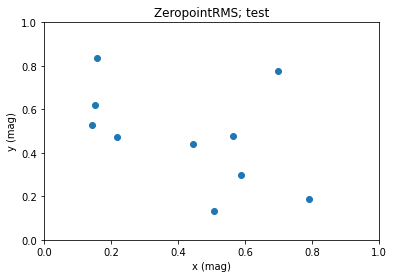

In [19]:
m = job.measurements['demo_photometry.ZeropointRMS']

plt.figure()
plt.scatter(m.extras['x'].quantity, m.extras['y'].quantity)
plt.xlabel('%s (%s)'%(m.extras['x'].label, m.extras['x'].unit.name))
plt.ylabel('%s (%s)'%(m.extras['y'].label, m.extras['y'].unit.name))
plt.title('%s; %s'%(m.metric_name.metric, job.meta["version"]))
plt.xlim(0, 1)
plt.ylim(0, 1)

Again, the particular values used in this example are just for demonstration purposes.